**Nama : Tio Rangga Yudhistira**

Mendeteksi klasifikasi SMS tergolong Spam atau tidak menggunakan LSTM.

In [1]:
%pip install numpy pandas nltk chardet matplotlib seaborn imbalanced-learn contractions wordcloud scikit-learn tensorflow


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import nltk
import chardet
import string
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from nltk.stem import WordNetLemmatizer
from contractions import contractions_dict 
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report, f1_score, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import Precision, Recall

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [3]:
import sys
print(sys.path)

['c:\\Users\\Tiora\\AppData\\Local\\Programs\\Python\\Python311\\python311.zip', 'c:\\Users\\Tiora\\AppData\\Local\\Programs\\Python\\Python311\\DLLs', 'c:\\Users\\Tiora\\AppData\\Local\\Programs\\Python\\Python311\\Lib', 'c:\\Users\\Tiora\\AppData\\Local\\Programs\\Python\\Python311', '', 'C:\\Users\\Tiora\\AppData\\Roaming\\Python\\Python311\\site-packages', 'C:\\Users\\Tiora\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32', 'C:\\Users\\Tiora\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32\\lib', 'C:\\Users\\Tiora\\AppData\\Roaming\\Python\\Python311\\site-packages\\Pythonwin', 'c:\\Users\\Tiora\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages']


In [5]:
rawdata = open('spam.csv', 'rb').read()
result = chardet.detect(rawdata)
encoding = result['encoding']

df = pd.read_csv('spam.csv', encoding=encoding)

In [6]:
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
2323,ham,Sorry dude. Dont know how i forgot. Even after...,NaN,NaN,NaN
3197,ham,7 lor... Change 2 suntec... Wat time u coming?,NaN,NaN,NaN
54,spam,SMS. ac Sptv: The New Jersey Devils and the De...,NaN,NaN,NaN
767,ham,"Sorry, I'll call later",NaN,NaN,NaN
1420,ham,No. She's currently in scotland for that.,NaN,NaN,NaN


In [7]:
df.shape

(5572, 5)

# Tahapan yang dilakukan
1. Data cleaning
2. EDA
3. Text Preprocessing
4. Model building
5. Evaluation


# 1. Data Cleaning

In [8]:
df.describe

<bound method NDFrame.describe of         v1                                                 v2 Unnamed: 2  \
0      ham  Go until jurong point, crazy.. Available only ...        NaN   
1      ham                      Ok lar... Joking wif u oni...        NaN   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3      ham  U dun say so early hor... U c already then say...        NaN   
4      ham  Nah I don't think he goes to usf, he lives aro...        NaN   
...    ...                                                ...        ...   
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham              Will Ì_ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...any other s...        NaN   
5570   ham  The guy did some bitching but I acted like i'd...        NaN   
5571   ham                         Rofl. Its true to its name        NaN   

     Unnamed: 3 Unnamed: 4  
0           NaN        N

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [10]:
# drop 3 kolom
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [11]:
df.sample(5)

,v1,v2
1568,ham,Today is ACCEPT DAY..U Accept me as? Brother S...
5299,ham,Well good morning mr . Hows london treatin' ya...
286,ham,Ok..
24,ham,Ffffffffff. Alright no way I can meet up with ...
4591,ham,Right it wasnt you who phoned it was someone w...


In [12]:
# rename kolom v1 : target & v2 : text
df.rename(columns={'v1':'target','v2':'text'},inplace=True)
df.sample(5)

,target,text
3420,spam,Welcome! Please reply with your AGE and GENDER...
4336,ham,on a Tuesday night r u 4 real
2510,ham,Yunny i'm walking in citylink now Ì_ faster co...
1419,ham,\Speak only when you feel your words are bette...
5446,ham,I am back. Good journey! Let me know if you ne...


In [13]:
encod = LabelEncoder()

In [14]:
# Pra-pemerosesan 
df['target'] = encod.fit_transform(df['target'])

In [15]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
# mengecek missing values
df.isnull().sum()

target    0
text      0
dtype: int64

In [17]:
# mengecek duplicate values
df.duplicated().sum()

np.int64(403)

In [18]:
# menghapus duplicates
df = df.drop_duplicates(keep='first')

In [19]:
df.duplicated().sum()

np.int64(0)

In [20]:
df.shape

(5169, 2)

# 2. Data Exploration / Exploratory Data Analysis (EDA)

In [21]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [22]:
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

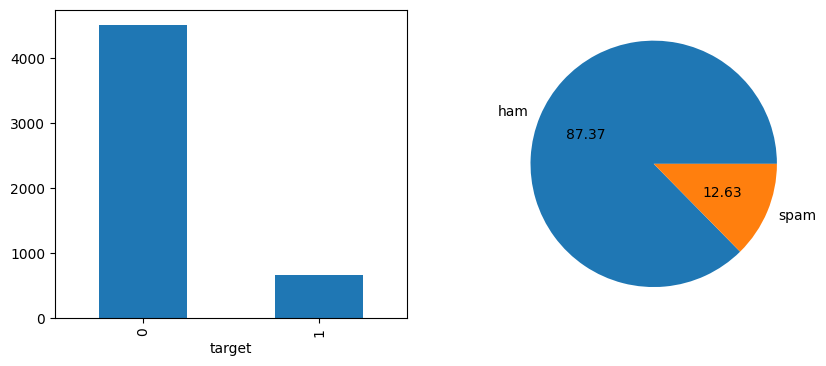

In [23]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
df['target'].value_counts().plot(kind='bar', ax=axs[0])
plt.pie(df['target'].value_counts(), labels=['ham','spam'],autopct='%0.2f')
plt.show()

*   ham = 87.37% lebih banyak dari spam.
*   Terlihat bahwa jumlah pada dataset tidak seimbang (imbalanced), sehingga perlu dihandle sebelum masuk ke train model

In [24]:

ham = len(df[df.target == 0])
spam = len(df[df.target == 1])
print("Percentage of ham: {:.2f}%".format((ham / (len(df.target))*100)))
print("Percentage of spam: {:.2f}%".format((spam / (len(df.target))*100)))

Percentage of ham: 87.37%
Percentage of spam: 12.63%


In [25]:
# Mendownload Lib NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tiora\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tiora\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tiora\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [26]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [27]:
nltk.download('punkt')
nltk.download('punkt_tab')

df['num_characters'] = df['text'].apply(len) 

df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x))) 
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tiora\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Tiora\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
C:\Users\Tiora\AppData\Local\Temp\ipykernel_17368\3884058037.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_characters'] = df['text'].apply(len)
C:\Users\Tiora\AppData\Local\Temp\ipykernel_17368\3884058037.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [28]:
df.head()

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [29]:
df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [30]:
# ham
df[df['target'] == 0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [31]:
#spam
df[df['target'] == 1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


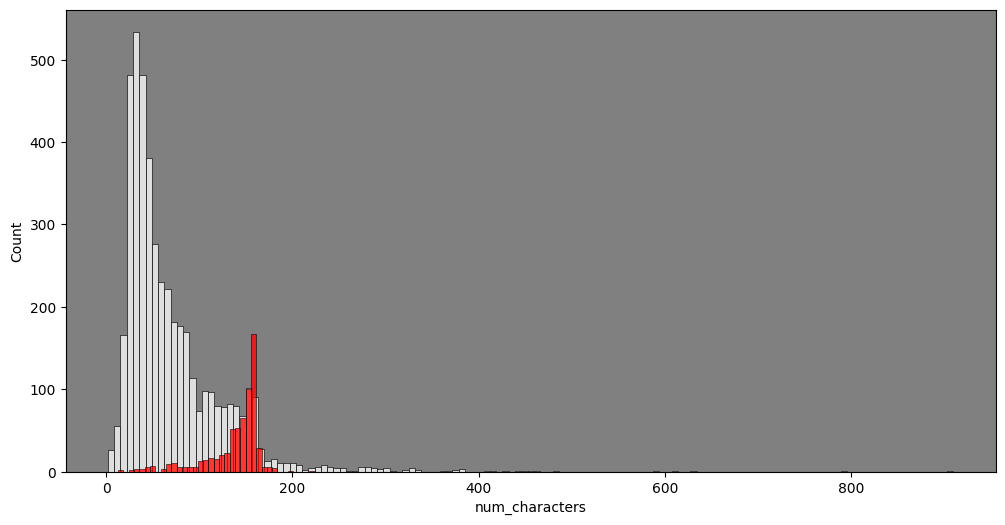

In [32]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.set_facecolor('grey')  

sns.histplot(df[df['target'] == 0]['num_characters'], color='white')
sns.histplot(df[df['target'] == 1]['num_characters'], color='red')

plt.show()

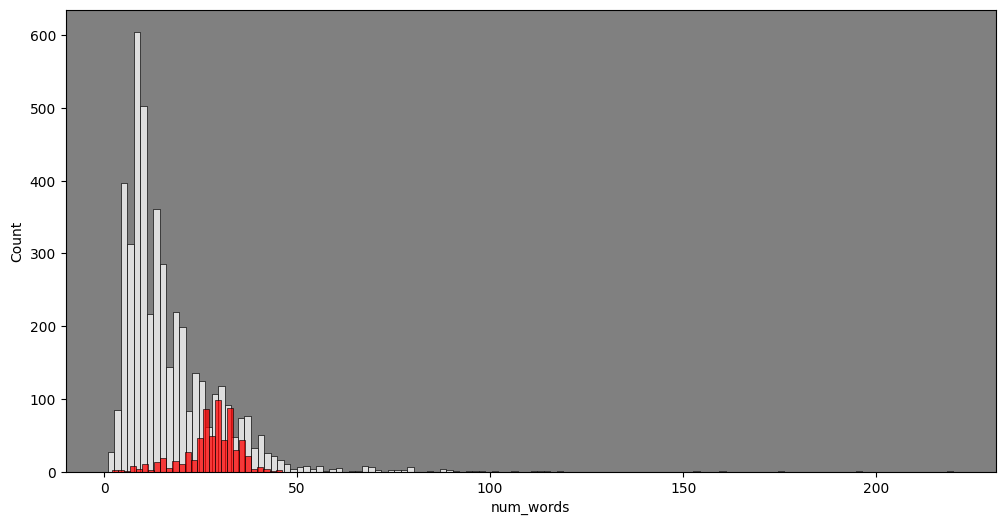

In [33]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.set_facecolor('grey') 

sns.histplot(df[df['target'] == 0]['num_words'], color='white')
sns.histplot(df[df['target'] == 1]['num_words'], color='red')

plt.show()

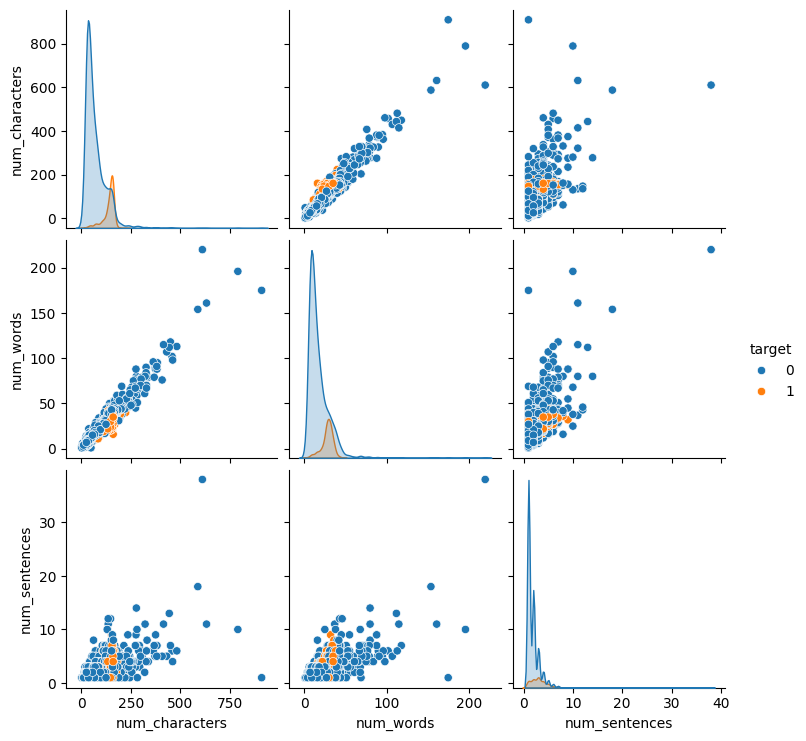

In [34]:
sns.pairplot(df,hue='target')

Histogram: Diagonal utama dari plot ini berisi histogram, yang menunjukkan distribusi dari masing-masing variabel (jumlah karakter, jumlah kata, dan jumlah kalimat). Histogram ini memberikan gambaran tentang sebaran data untuk masing-masing kategori, yaitu ham (1) dan spam (2).

<Axes: >

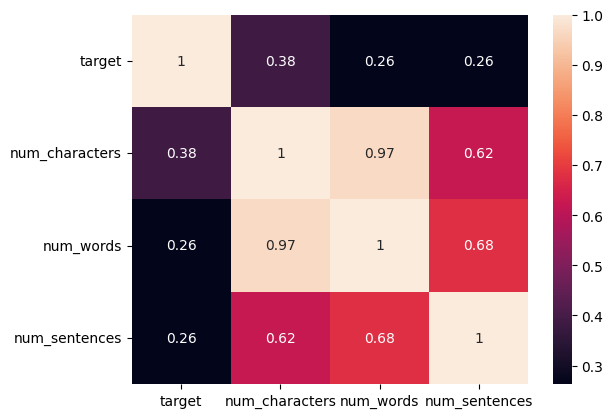

In [35]:
df_numeric = df.select_dtypes(include=[np.number])

sns.heatmap(df_numeric.corr(), annot=True)

# 3. Text Preprocessing

In [36]:
import re

def transform_text(text):
    lemmatizer = WordNetLemmatizer()
    
    text = text.lower()
    
    
    text = ' '.join([contractions_dict.get(word, word) for word in text.split()])
    
   
    text = word_tokenize(text)
    
    
    text = [re.sub(r'[^a-zA-Z0-9]', '', word) for word in text]
    
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word not in stop_words and word not in string.punctuation]
    
    text = [lemmatizer.lemmatize(word) for word in text] # Mengubah kata menjadi bentuk dasar yang mungkin tidak selalu benar secara gramatikal
    
    return " ".join(text)

In [37]:
transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")

'going home soon want talk stuff anymore tonight k cried enough today'

In [38]:
df['text'][10]

"I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."

In [39]:
ps = PorterStemmer()
ps.stem('loving')

'love'

In [40]:
df['transformed_text'] = df['text'].apply(transform_text)

C:\Users\Tiora\AppData\Local\Temp\ipykernel_17368\283536690.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transformed_text'] = df['text'].apply(transform_text)


In [41]:
df.head(5)

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think go usf life around though


In [42]:
df.columns

Index(['target', 'text', 'num_characters', 'num_words', 'num_sentences',
       'transformed_text'],
      dtype='object')

In [43]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

In [44]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

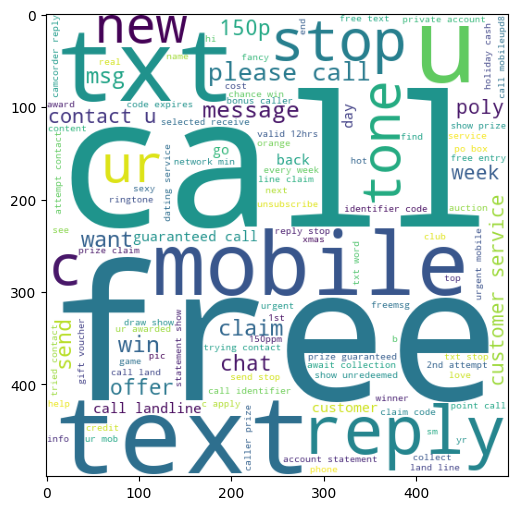

In [45]:
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

In [46]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))

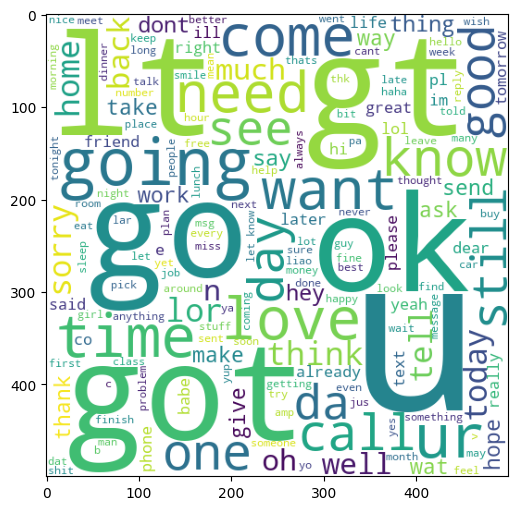

In [47]:
plt.figure(figsize=(15,6))
plt.imshow(ham_wc)

In [48]:
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

In [49]:
len(spam_corpus)

10905

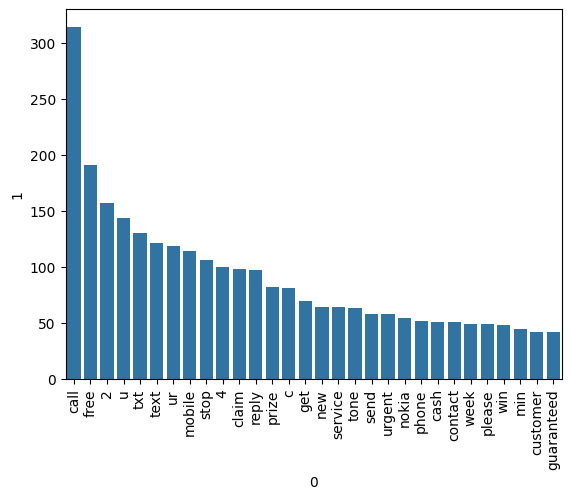

In [50]:
sns.barplot(x=pd.DataFrame(Counter(spam_corpus).most_common(30))[0], y=pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

In [51]:
ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

In [52]:
len(ham_corpus)

36079

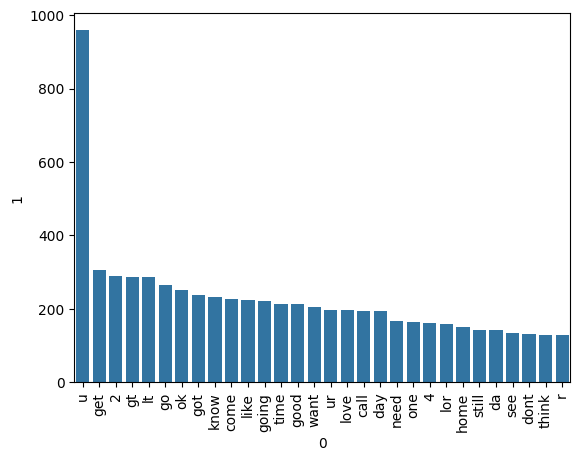

In [53]:
sns.barplot(x=pd.DataFrame(Counter(ham_corpus).most_common(30))[0], y=pd.DataFrame(Counter(ham_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

# 4. Model Building

Split Train & Test Data

In [54]:
X_train, X_test, y_train, y_test = train_test_split(df['transformed_text'], df['target'], test_size=0.2, random_state=42)

- Menggunakan  teknik Random Oversampling

In [55]:
oversampler = RandomOverSampler(random_state=42)

- Klasifikasi menggunakan LSTM

In [56]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [57]:
vocab_size = len(tokenizer.word_index) + 1

max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

In [58]:
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_pad, y_train)

In [62]:
def create_model():
    model = Sequential()

    model.add(Embedding(vocab_size, 32, input_length=max_length))

    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))

    model.add(Dropout(0.6))
 
    model.add(Dense(1, activation='sigmoid'))  # Mengubah output neuron menjadi nilai antara 0 dan 1, yang bisa diinterpretasikan sebagai probabilitas.
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])

    return model
    

In [64]:
model = create_model()
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_pad, y_train, epochs=50, batch_size=64, validation_data=(X_test_pad, y_test), callbacks=[early_stop])

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 158ms/step - accuracy: 0.8774 - loss: 0.6765 - precision_1: 0.5060 - recall_1: 0.0827 - val_accuracy: 0.9014 - val_loss: 0.3972 - val_precision_1: 0.9057 - val_recall_1: 0.3310
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.9388 - loss: 0.2807 - precision_1: 0.8947 - recall_1: 0.5689 - val_accuracy: 0.9642 - val_loss: 0.1982 - val_precision_1: 0.9500 - val_recall_1: 0.7862
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.9744 - loss: 0.1474 - precision_1: 0.9718 - recall_1: 0.8150 - val_accuracy: 0.9710 - val_loss: 0.1065 - val_precision_1: 0.9323 - val_recall_1: 0.8552
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step - accuracy: 0.9814 - loss: 0.0950 - precision_1: 0.9675 - recall_1: 0.8780 - val_accuracy: 0.9749 - val_loss: 0.0817 - val_precision_1: 0.9343 - val_recall_1: 0.8828
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.9877 - loss: 0.0682 - precision_1: 0.9811 - recall_1: 0.917

In [65]:
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print('F1 Score:', f1)
print('Precision:', precision)
print('Recall:', recall)

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
F1 Score: 0.9314079422382672
Precision: 0.9772727272727273
Recall: 0.8896551724137931


Model Evaluation

In [66]:
loss, accuracy, precision, recall = model.evaluate(X_test_pad, y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9816 - loss: 0.0692 - precision_1: 0.9773 - recall_1: 0.8897
Loss:  0.06916887313127518
Accuracy:  0.9816247820854187
Precision:  0.9772727489471436
Recall:  0.8896551728248596


In [67]:
y_pred_proba = model.predict(X_test_pad)

y_pred = (y_pred_proba > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)


classification_rep = classification_report(y_test, y_pred)

print('Accuracy score:', accuracy)
print('\nClassification Report:\n', classification_rep)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Accuracy score: 0.9816247582205029

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       889
           1       0.98      0.89      0.93       145

    accuracy                           0.98      1034
   macro avg       0.98      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034



Mengevaluasi model menggunakan Roc Auc Curve Score

In [68]:
y_pred_proba = model.predict(X_test_pad)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [69]:

roc_auc = roc_auc_score(y_test, y_pred_proba)

print('ROC AUC score:', roc_auc)

ROC AUC score: 0.9909623366044762


In [70]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

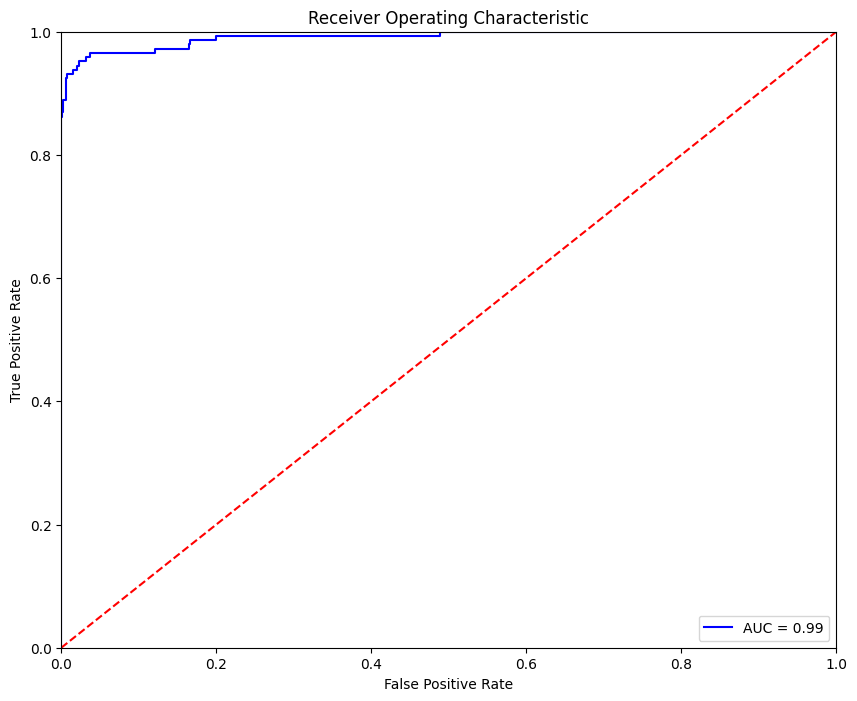

In [71]:
# Plot ROC curve
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [72]:
import gradio as gr
def predict_spam(message):
    """
    Fungsi prediksi yang alurnya disamakan dengan fungsi manual predict_message_spam().
    Teks mentah langsung di-tokenisasi.
    """
   
    message_seq = tokenizer.texts_to_sequences([message])
    message_pad = pad_sequences(message_seq, maxlen=max_length, padding='pre')

   
    prediction_prob = model.predict(message_pad)[0][0]
 
    if prediction_prob > 0.5:
       
        return {"Spam": float(prediction_prob), "Ham": float(1 - prediction_prob)}
    else:
     
        return {"Ham": float(1 - prediction_prob), "Spam": float(prediction_prob)}


iface = gr.Interface(
    fn=predict_spam,
    inputs=gr.Textbox(lines=5, label="Masukkan Pesan SMS"),
    outputs=gr.Label(label="Hasil Klasifikasi"),
    title="🤖 Detektor SMS Spam (LSTM)",
    description="Masukkan sebuah pesan SMS untuk mendeteksi apakah pesan tersebut tergolong 'Spam' atau 'Ham'.",
    examples=[
        ["Congratulations! You've won a $1,000 gift card. Click here to claim: [link]"],
        ["Hey, are you free for dinner tonight? Let me know."],
        ["URGENT: Your account has been compromised. Please verify your details immediately at [link]"]
    ]
)

# Luncurkan kembali UI
iface.launch()

c:\Users\Tiora\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


In [73]:
model.save('spam_detector_model.h5')

In [74]:
import pickle

with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


# Kesimpulan

1. Model yang latih memiliki performa yang sangat baik. Dengan menggunakan 28 epoch dan batch size 64, model berhasil mencapai akurasi 98.26% pada data validasi.

2. F1 Score adalah rata-rata harmonik dari Precision dan Recall, dan skor ini mencerminkan keseimbangan antara kedua metrik tersebut. Nilai yang tinggi menunjukkan bahwa model memiliki performa yang baik dalam menangani kedua kelas.

3. Precision adalah rasio antara True Positives (TP) dan jumlah total yang diprediksi Positif (TP + FP). Nilai yang tinggi menunjukkan bahwa model tidak banyak membuat kesalahan tipe I (False Positives).

4. Recall adalah rasio antara True Positives (TP) dan jumlah total yang sebenarnya Positif (TP + FN). Nilai yang tinggi menunjukkan bahwa model tidak banyak membuat kesalahan tipe II (False Negatives).
Dalam hal ini, model memiliki nilai yang baik untuk semua metrik tersebut, menunjukkan bahwa model dapat memprediksi kedua kelas dengan baik.

5. ROC AUC Score: Nilai ROC AUC adalah 0.9884, yang sangat dekat dengan 1. Ini menunjukkan bahwa model sangat baik dalam membedakan antara kelas positif dan negatif.